In [5]:
import os
import pickle

import matplotlib.pyplot as plt
import mne
import numpy as np
import pandas as pd
from tqdm import tqdm

from mne.preprocessing import ICA

from Brain_to_Image.dataset_formats import (MDB2022_MNIST_EP_params,
                                            keys_MNIST_EP)

from asrpy import ASR
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
#%matplotlib widget
#%matplotlib qt

print(os.getcwd())
dataset = "MNIST_EP"
root_dir = f"Datasets/MindBigData MNIST of Brain Digits/{dataset}"
if True:
    # ## TRAIN
    input_file = f"train_MindBigData2022_{dataset}.csv"
    output_file = f"train_MindBigData2022_{dataset}.pkl"
else:
    ## TEST
    input_file = f"test_MindBigData2022_{dataset}.csv"
    output_file = f"test_MindBigData2022_{dataset}.pkl"

label = 'digit_label'
## MNIST_MU sf = 220, 440 samples , MNIST_EP sf = 128, 256 samples , MNIST_IN sf = 128, 256 samples
if "_EP" in dataset or "_IN" in dataset:
    sample_rate = 128  #Hz
else:
    sample_rate = 220  #Hz
# Define notch frequencies and widths
notch_freqs = [ 50] #, 60]  # Line noise frequencies (50 Hz and harmonics)
notch_widths = [1] #, 2]  # Notch widths (in Hz)
# Define filter parameters
lowcut = 0.4 # 0.4  # Low-cutoff frequency (Hz)
highcut = 60 # 110  # High-cutoff frequency (Hz)
class_labels = [0,1,2,3,4,5,6,7,8,9]
keys_ = ['T7','P7','T8','P8']
keys_ext = ['EEGdata_T7','EEGdata_P7','EEGdata_T8','EEGdata_P8']

c:\Users\timta\Documents\Msc Notes\CMP9140-2324 Research Project


In [3]:
montage = mne.channels.make_standard_montage('easycap-M1')

prefix = [""]
ix = 0
print(f"{root_dir}/{prefix[ix]}{output_file}")
all_data_array = pd.read_pickle(f"{root_dir}/{prefix[ix]}{output_file}")
all_data_array = all_data_array[all_data_array[label]!=-1]
all_data_array[label].value_counts()

Datasets/MindBigData MNIST of Brain Digits/MNIST_EP/train_MindBigData2022_MNIST_EP.pkl


3    5294
5    5256
9    5250
8    5241
6    5218
0    5212
2    5196
1    5080
4    5079
7    5069
Name: digit_label, dtype: int64

UsSe to sample from data for testing

In [ ]:
record = 256
class_label = 1
#data_array = all_data_array[all_data_array[label]==class_label]  #[keys_ext]
#data_array.info()
sample_size = 10
sample_indexs = all_data_array.sample(n=sample_size).index.tolist()
data_array = all_data_array.loc[sample_indexs]

Identify all training epochs which are deemed good by applying threshold

In [4]:
# Create a 1x256 array of zeros
stimulus = np.zeros(256)
# Set a peak of 1 at position 10 for 2 positions
stimulus[16:240] = 1  # 1.5 seconds
processed_data = []
keys_ = []
for key in keys_MNIST_EP: #[8:12]:    # [8:12]
    keys_.append(key.split("_")[1])
#keys_.append("STI014")
n_channels = len(keys_)
ch_types = ['eeg'] * (n_channels) # - 1)
#ch_types.append('stim')
info = mne.create_info(ch_names=keys_, sfreq=sample_rate, ch_types=ch_types)
passed_idx = []
rejected_idx = []
verbose = False
for index, row in tqdm(all_data_array.iterrows()):
    #data = row[keys_MNIST_EP].values.tolist()
    
    data = np.array(row[keys_MNIST_EP].values.tolist(), dtype=object)
    raw = mne.io.RawArray(data, info, verbose=False)
    raw.set_montage(montage, verbose=False)
    # could move filter to after epoch reject check
    raw.filter(l_freq=lowcut, h_freq=highcut,verbose=False)
    raw.set_eeg_reference(ref_channels='average',ch_type='eeg',projection=False,verbose=False)
    ## Create fixed length Epochs
    epochs = mne.make_fixed_length_epochs(raw, duration=2, preload=True,verbose=False)
    epochs_clean = epochs.drop_bad(reject={'eeg': 100e-0},verbose=False)
    if epochs_clean:
        # could filter here
        #epochs_clean.filter(l_freq=lowcut, h_freq=highcut)
        passed_idx.append(index)
        # clean_df = epochs_clean.to_data_frame()
        # clean_df[label] = row[label]
        # processed_data.append(clean_df)
        # for epoch in epochs_clean:
        #     clean_df = pd.DataFrame(epoch, columns=keys_)
        #     clean_df[label] = row[label]
        #     processed_data.append(clean_df)
    else:
        rejected_idx.append(index)
#processed_df = pd.concat(processed_data, ignore_index=True)

51895it [20:22, 42.46it/s]


In [7]:
mne_epoch_rejection = {'passed':passed_idx,'reject':rejected_idx}
print(f"{root_dir}/mne_epoch_rejection_idx.pkl")
with open(f"{root_dir}/mne_epoch_rejection_idx.pkl", 'wb') as f:
    pickle.dump(mne_epoch_rejection, f)

Datasets/MindBigData MNIST of Brain Digits/MNIST_EP/mne_epoch_rejection_idx.pkl


In [8]:
data_array = all_data_array.loc[passed_idx]
data_array[label].value_counts()

3    3950
9    3917
5    3916
6    3868
8    3861
0    3845
2    3809
1    3798
7    3780
4    3765
Name: digit_label, dtype: int64

In [11]:

record = 5502
# Create a 1x256 array of zeros
stimulus = np.zeros(256)
# Set a peak of 1 at position 10 for 2 positions
stimulus[16:240] = 1  # 1.5 seconds
### used to check the creation of raw mne object
d = []
keys_ = []
for key in keys_MNIST_EP: #[8:12]:    # [8:12]
    d.append(data_array.iloc[record][key])
    keys_.append(key.split("_")[1])
# and stim channel
#d.append(stimulus)

d = np.array(d, dtype=object)
n_channels = len(keys_)
ch_types = ['eeg'] * (n_channels) # - 1)
#ch_types.append('stim')
info = mne.create_info(ch_names=keys_, sfreq=sample_rate, ch_types=ch_types)
# Create Raw object
raw = mne.io.RawArray(d, info)
raw.set_montage(montage, verbose=False)



Creating RawArray with float64 data, n_channels=14, n_times=256
    Range : 0 ... 255 =      0.000 ...     1.992 secs
Ready.


Measurement date,Unknown
Experimenter,Unknown
Participant,Unknown
Digitized points,17 points
Good channels,14 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,128.00 Hz
Highpass,0.00 Hz
Lowpass,64.00 Hz


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.4 - 60 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.40
- Lower transition bandwidth: 0.40 Hz (-6 dB cutoff frequency: 0.20 Hz)
- Upper passband edge: 60.00 Hz
- Upper transition bandwidth: 4.00 Hz (-6 dB cutoff frequency: 62.00 Hz)
- Filter length: 1057 samples (8.258 s)

Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished


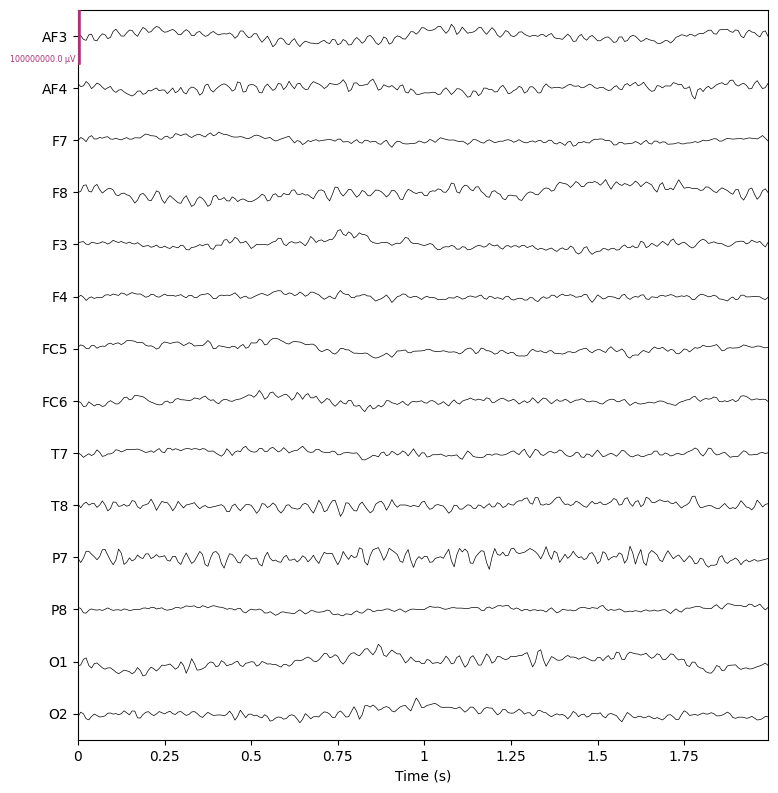

Effective window size : 2.000 (s)
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 256 original time points ...
0 bad epochs dropped


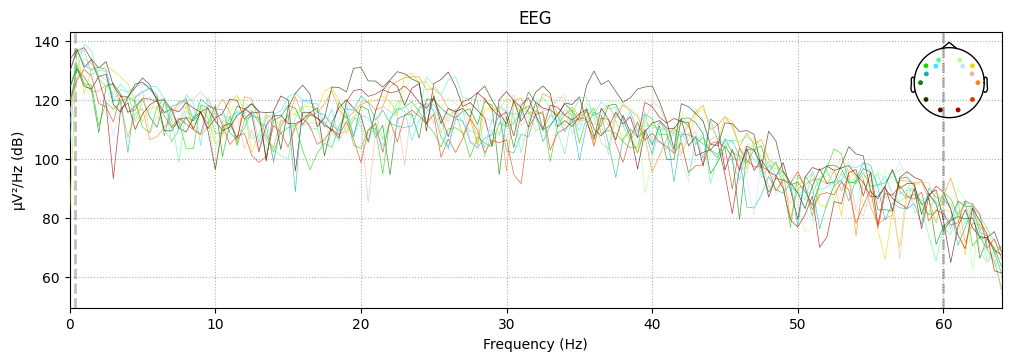

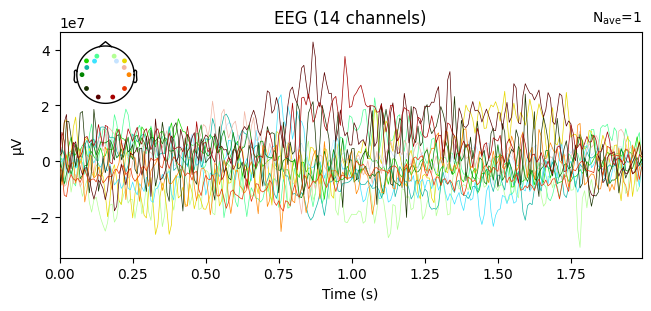

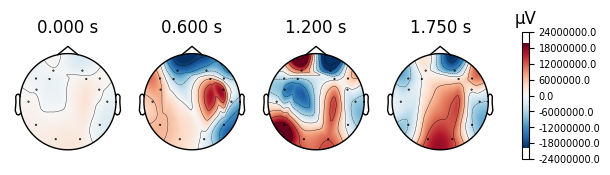

No projector specified for this dataset. Please consider the method self.add_proj.


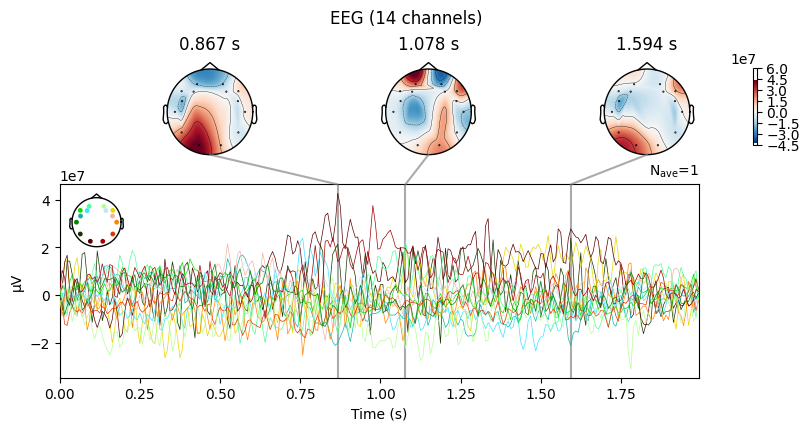

Fitting ICA to data using 14 channels (please be patient, this may take a while)
Selecting by number: 4 components
Fitting ICA took 0.0s.


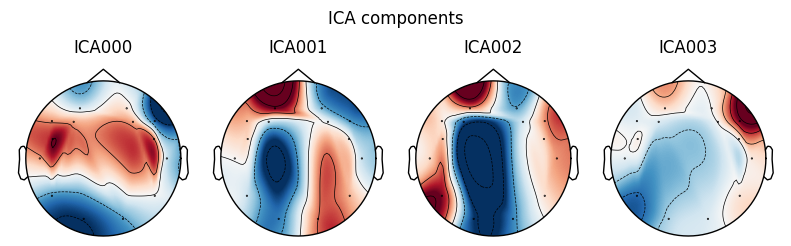

Creating RawArray with float64 data, n_channels=4, n_times=256
    Range : 0 ... 255 =      0.000 ...     1.992 secs
Ready.


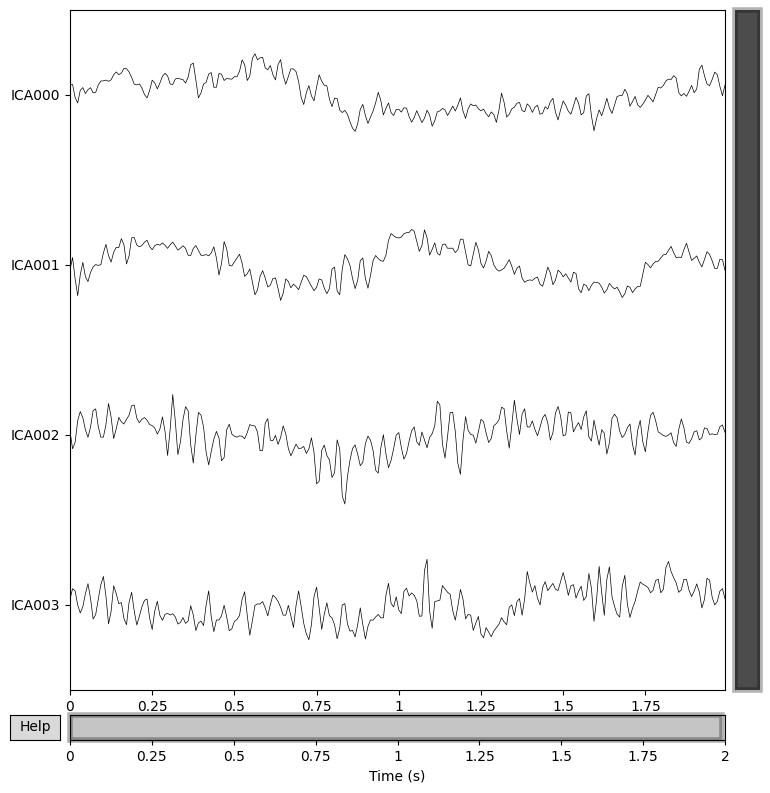

In [12]:
raw.filter(l_freq=lowcut, h_freq=highcut)
raw.set_eeg_reference(ref_channels='average',ch_type='eeg',projection=False)
raw.plot(duration=2, n_channels=len(raw.ch_names), scalings=dict(eeg=50e-0), show_scrollbars=False);
raw.compute_psd(fmax=64).plot(picks="data", exclude="bads", amplitude=False)
epoch = mne.make_fixed_length_epochs(raw, duration=2, preload=True)

evoked = epoch.average(picks='eeg') # ['T7','P7','T8','P8']
evoked.plot();
evoked.plot_topomap(times=[0,0.6,1.2,1.75]);  #
evoked.plot_joint();

ica = mne.preprocessing.ICA(n_components=4, random_state=42)
ica.fit(raw)
ica.plot_components();
ica.plot_sources(raw);



In [ ]:
raw_bandpass = raw.copy()
raw_bandpass.set_eeg_reference(ref_channels='average',ch_type='eeg',projection=False)
raw_bandpass.plot(
        duration=2, n_channels=len(raw.ch_names), scalings=dict(eeg=25e-0), show_scrollbars=False
    );
raw_bandpass.compute_psd(fmax=60).plot(picks="data", exclude="bads", amplitude=False);
raw_bandpass.info

In [ ]:
ica = mne.preprocessing.ICA(n_components=4, random_state=42)
ica.fit(raw_bandpass)
ica.plot_components();
ica.plot_sources(raw_bandpass);

In [ ]:
ica.exclude = [0]
ica.apply(raw_bandpass)
raw_bandpass.plot(
        duration=2, n_channels=len(raw.ch_names), scalings=dict(eeg=25e-0), show_scrollbars=False
    );
raw_bandpass.compute_psd(fmax=60).plot(picks="data", exclude="bads", amplitude=False);

In [ ]:
l_cutoff = lowcut
h_cutoff = highcut
raw_bandpass = raw.copy().filter(l_freq=l_cutoff, h_freq=h_cutoff)
raw_bandpass.set_eeg_reference(ref_channels='average',ch_type='eeg',projection=False)
raw_bandpass.plot(
        duration=2, n_channels=len(raw.ch_names), scalings=dict(eeg=25e-0), show_scrollbars=False
    );

#fig.suptitle(f"High-pass filtered at {l_cutoff} Hz, {h_cutoff} Hz", size="xx-large", weight="bold")

raw_bandpass.compute_psd(fmax=60).plot(picks="data", exclude="bads", amplitude=False);

In [ ]:
events = mne.make_fixed_length_events(raw_bandpass, id=100, start=0, duration=0.250, overlap=0.03125)
#events = mne.make_fixed_length_events(raw_bandpass, id=100, start=0.125, duration=1.75)
raw_bandpass.plot(events=events, duration=2, n_channels=len(raw.ch_names), scalings=dict(eeg=25e-0), show_scrollbars=False);

In [ ]:
epochs = mne.Epochs(raw_bandpass,events,tmin=-0.0625,tmax=0.250)
print(epochs.info)
av_epochs = epochs.average()

av_epochs.plot(spatial_colors=True, titles="before ASR");  #_psd(fmin=4,fmax=20);
#av_epochs.plot_psd();

In [ ]:
asr = ASR(sfreq=raw_bandpass.info["sfreq"], cutoff=20)
asr.fit(raw_bandpass)
raw_asr = asr.transform(raw_bandpass)

asr_epochs = mne.Epochs(raw_bandpass,events,tmin=-0.0625,tmax=0.250).average()
asr_epochs.plot(spatial_colors=True, titles="after ASR");

In [ ]:
av_epochs.plot_joint();

In [ ]:
av_epochs.plot_image();

In [ ]:
av_epochs.plot_topomap();

In [ ]:
av_epochs.compute_psd().plot(picks="data", exclude="bads", amplitude=False);
av_epochs.compute_psd().plot(average=True, picks="data", exclude="bads", amplitude=False);

In [ ]:
def add_arrows(axes):
    """Add some arrows at 60 Hz and its harmonics."""
    for ax in axes:
        freqs = ax.lines[-1].get_xdata()
        psds = ax.lines[-1].get_ydata()
        for freq in (40,50,60):
            idx = np.searchsorted(freqs, freq)
            # get ymax of a small region around the freq. of interest
            y = psds[(idx - 4) : (idx + 5)].max()
            ax.arrow(
                x=freqs[idx],
                y=y + 18,
                dx=0,
                dy=-12,
                color="red",
                width=0.1,
                head_width=3,
                length_includes_head=True,
            )

In [ ]:
# raw_notch = raw_bandpass.copy().notch_filter(freqs=[50], picks="data")
# for title, data in zip(["Un", "Notch "], [raw, raw_notch]):
#     fig = data.compute_psd(fmax=64).plot(
#         average=True, amplitude=False, picks="data", exclude="bads"
#     )
#     fig.suptitle(f"{title}filtered", size="xx-large", weight="bold")
#     add_arrows(fig.axes[:2])

In [ ]:

#events = mne.find_events(raw,min_duration=0.01)

ica = ICA(n_components=0.9,random_state=47, max_iter=1500)
ica.fit(epochs)
#ica.exclude = [0,1]
#ica.apply(raw_bandpass)

In [ ]:
ica.plot_components(ch_type='eeg',show_names=True);

In [ ]:
ica.plot_overlay(raw_bandpass, picks="eeg");

In [ ]:
ica.plot_properties(epochs);